This notebook has been adapted from TroddenSpade ([Github](https://github.com/TroddenSpade/Maximum-Entropy-Deep-IRL/blob/main/README.md))

## Inverse Reinforcement Learning

Inverse Reinforcement Learning (IRL) is a method used to infer the underlying reward function from observed behavior, typically when an agent (e.g., a human or robot) is demonstrating a task. Understanding the reward function helps in understanding the motivations behind the observed actions, which can then be used to replicate or improve the behavior in new contexts.

MaxEnt IRL is a popular approach within IRL that leverages the principle of maximum entropy. This principle asserts that, among all possible distributions, the one that best represents the current state of knowledge without introducing any additional bias is the one with the highest entropy.

## Key Concepts:

1. **Reward Function**:
   The reward function $R(s)$ is a mapping from states (or state-action pairs) to real numbers. The goal of MaxEnt IRL is to learn this reward function from demonstrations.

2. **Trajectory**:
   A trajectory $\tau$ is a sequence of states and actions $\{(s_1, a_1), (s_2, a_2), \ldots, (s_T, a_T)\}$ observed from the expert's behavior.

3. **Policy**:
   A policy $\pi(a|s)$ represents the probability of taking action $a$ in state $s$. The expert's policy is assumed to be optimal or near-optimal with respect to the unknown reward function.

4. **Maximum Entropy Principle**:
   The principle of maximum entropy is used to resolve ambiguities by choosing the distribution $p(\tau|R)$ that maximizes entropy, subject to constraints imposed by the observed data. This ensures that no additional assumptions are made beyond what is supported by the data.

## The MaxEnt IRL Algorithm:

1. **Modeling the Probability of a Trajectory**:
   The probability of an expert generating a trajectory $\tau$ under the reward function $R$ is modeled as:
   $$
   p(\tau|R) = \frac{1}{Z(R)} \exp \left( \sum_{(s,a) \in \tau} R(s) \right)
   $$
   where $Z(R)$ is the partition function ensuring the distribution sums to one:
   $$
   Z(R) = \sum_{\tau} \exp \left( \sum_{(s,a) \in \tau} R(s) \right)
   $$

2. **Optimization Objective**:
   The objective is to find the reward function $R$ that maximizes the likelihood of the observed trajectories, subject to the maximum entropy constraint. This can be formulated as:
   $$
   R^* = \arg \max_R \sum_{\tau \in \mathcal{D}} \log p(\tau | R)
   $$
   where $\mathcal{D}$ is the set of observed trajectories.

3. **Feature Expectations**:
   Let $\phi(s)$ be a feature vector representing state $s$. The expected feature count under the learned policy should match the empirical feature count from the demonstrations:
   $$
   \mathbb{E}_{\pi_R}[\phi(s)] = \mathbb{E}_{\mathcal{D}}[\phi(s)]
   $$

4. **Gradient Descent**:
   The optimization problem is typically solved using gradient-based methods. The gradient of the log-likelihood with respect to the reward parameters $\theta$ is given by:
   $$
   \nabla_\theta \log p(\mathcal{D} | R_\theta) = \mathbb{E}_{\mathcal{D}}[\phi(s)] - \mathbb{E}_{p(\tau|R_\theta)}[\phi(s)]
   $$
   This gradient guides the update of reward parameters to better match the observed behavior.

## Advantages of MaxEnt IRL:

- **Robustness**: By considering the distribution with maximum entropy, MaxEnt IRL avoids making unnecessary assumptions, leading to more robust reward function estimates.
- **Probabilistic Framework**: Provides a natural probabilistic interpretation of the problem, allowing for uncertainty modeling and probabilistic inference.

## Applications:

MaxEnt IRL has been applied in various domains, including robotics, autonomous driving, game AI, and human-computer interaction. It is particularly useful in scenarios where it is challenging to specify a reward function directly, but expert demonstrations are available.

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import product

import torch
import torch.nn as nn

## GridWorld

In [2]:
class GridWorld:
    def __init__(self, grid_size=5, wind=0.2):
        # (0,0) bottom left corner (x,y)
        self.names = ["Right", "Down", "Left", "Up"]
        self.actions = [(1,0),(0,1),(-1,0),(0,-1)]
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.wind = float(wind)

        self.grid_size = grid_size
        self.grid = np.zeros((grid_size, grid_size))

        self.features = np.eye(self.n_states)
        self.dynamics = self.transition_probabilities()
        self.real_rewards = np.array([self.reward(s) for s in range(self.n_states)])
        self.state = 0


    def reward(self, state_p):
        return 1 if state_p == self.n_states-1 else 0


    def reset(self):
        self.state = 0
        return self.state


    def step(self, a):
        probs = self.dynamics[:, a, self.state]
        self.state = np.random.choice(self.n_states, p=probs)
        return self.state


    def transition_probabilities(self):
        dynamics = np.zeros((self.n_states, self.n_actions, self.n_states))
        # S_t+1, A_t, S_t
        for s in range(self.n_states):
            x, y = s%self.grid_size, s//self.grid_size
            for a in range(self.n_actions):
                x_a, y_a = self.actions[a]
                for d in range(self.n_actions):
                    x_d, y_d = self.actions[d]
                    if 0 <= x+x_d < self.grid_size and 0 <= y+y_d < self.grid_size:
                        dynamics[(x+x_d) + (y+y_d)*self.grid_size, a, s] += self.wind/self.n_actions
                    else:
                        dynamics[s, a, s] += self.wind/self.n_actions
                if 0 <= x+x_a < self.grid_size and 0 <= y+y_a < self.grid_size:
                    dynamics[(x+x_a) + (y+y_a)*self.grid_size, a, s] += 1 - self.wind
                else:
                    dynamics[s, a, s] += 1 - self.wind

        return dynamics


    def test(self):
        for s in range(self.n_states):
            print("/// State: ", s)
            for a in range(self.n_actions):
                print("/// Action: ", self.names[a])
                probs = self.dynamics[:, a, s]
                print(probs.reshape(-1, self.grid_size))


    def optimal_policy(self, state):
        x, y = state%self.grid_size, state//self.grid_size
        if x > y:
            return 1
        elif x < y:
            return 0
        else:
            return np.random.randint(2)


    def generate_trajectories(self, num, length, policy=None):
        if not policy:
            policy = self.optimal_policy

        trajs = []
        for n in range(num):
            t = []
            state = self.reset()
            for i in range(length):
                action = policy(state)
                state_p = self.step(action)
                t.append([state, action])
                state = state_p
            trajs.append(t)
        return np.array(trajs)

In [3]:
# Update the value function according to the reward function and compute the new policy.
def value_iteration(threshold, env, rewards, discount=0.01):
    transition = env.dynamics
    V = np.zeros(env.n_states)
    delta = np.inf

    #update value function
        

    # compute new policy


    # Normailize the policy
    

To allow for computation with states, we use so-called features.
Features are, in this case, defined as a function $\phi: S \to \mathbb{R}^d$, mapping states to $d$-dimensional vectors, and can be arbitrarily chosen.
In general, we assume that $\phi(\tau) = \sum_{t = 1}^{|\tau|} \phi(s_t)$ where $|\tau|$ denotes the length of the trajectories (visited states), i.e. that the features of a trajectory $\tau$ are the sum of the features of the states visited by this trajectory, counting repetitions.

In [4]:
class MaximumEntropy:
    def __init__(self, env, trajectories, features, lr=0.002, discount=0.9):
        

    def get_rewards(self):
        return self.rews


    def expected_features(self):
        


    def expected_state_visitation_frequency(self, policy):
        # probability of visiting the initial state
       

        # Compute the state visitation frequency 𝜇
        

    def train(self, n_epochs, save_rewards=True, plot=False):
        

In [5]:
grid_size = 5
random_rate = 0.3
num_trajectories = 50
len_trajectory = 30

n_epochs = 500
discount = 0.9
lr = 0.01

In [6]:
gw = GridWorld(grid_size, random_rate)
trajectories = gw.generate_trajectories(num_trajectories, len_trajectory)
features = np.eye(gw.n_states)

  0%|          | 0/500 [00:00<?, ?it/s]

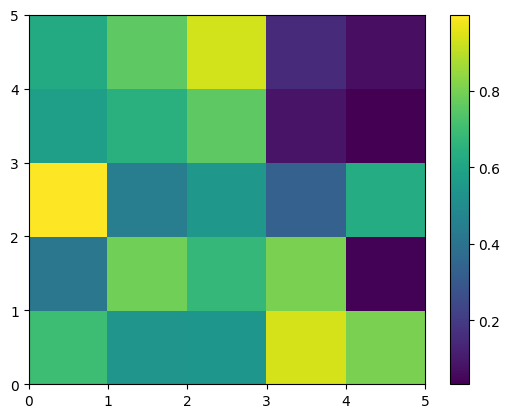

 10%|█         | 50/500 [00:14<02:58,  2.52it/s]

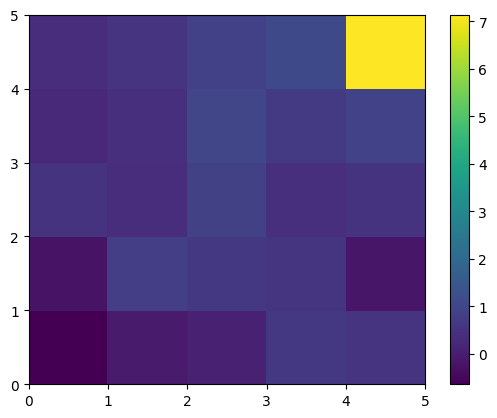

 20%|██        | 100/500 [00:27<01:13,  5.42it/s]

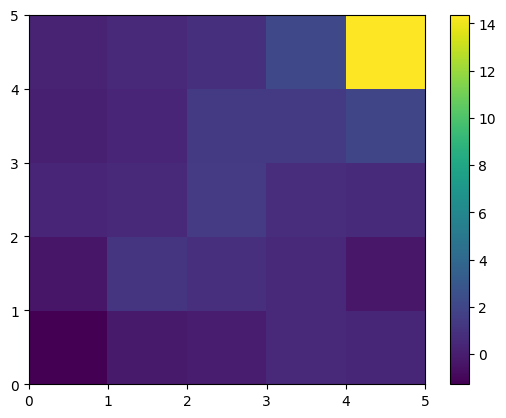

 30%|███       | 150/500 [00:40<00:47,  7.40it/s]

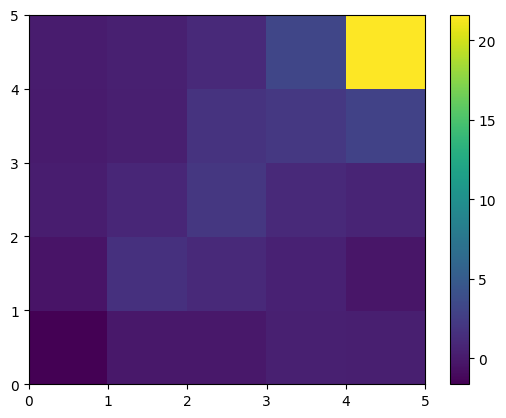

 40%|███▉      | 199/500 [00:46<00:26, 11.44it/s]

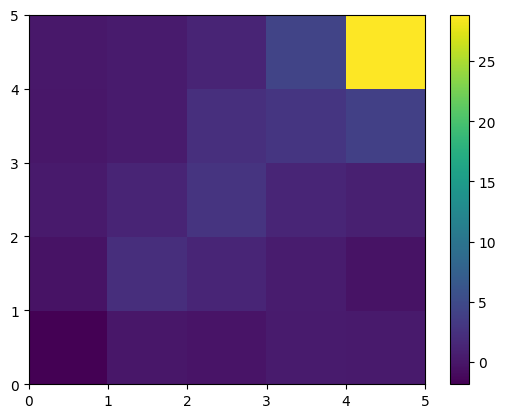

 50%|████▉     | 249/500 [00:51<00:21, 11.71it/s]

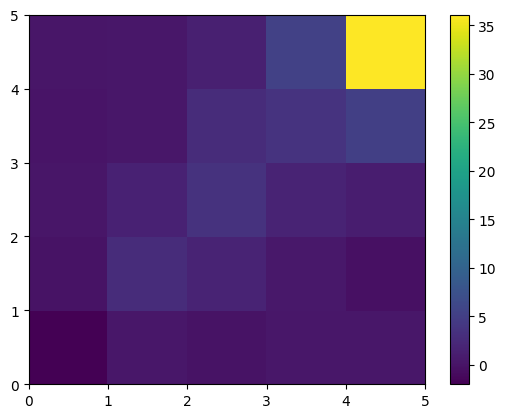

 60%|██████    | 300/500 [00:56<00:24,  8.12it/s]

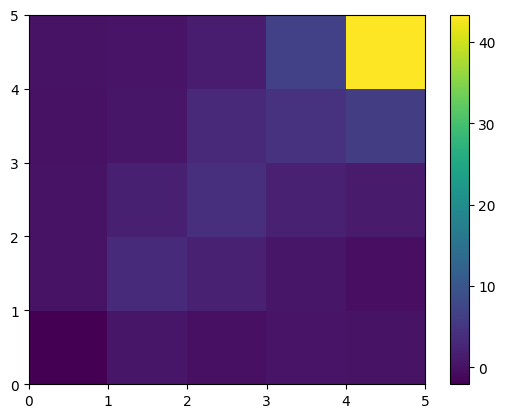

 70%|███████   | 350/500 [01:01<00:13, 11.49it/s]

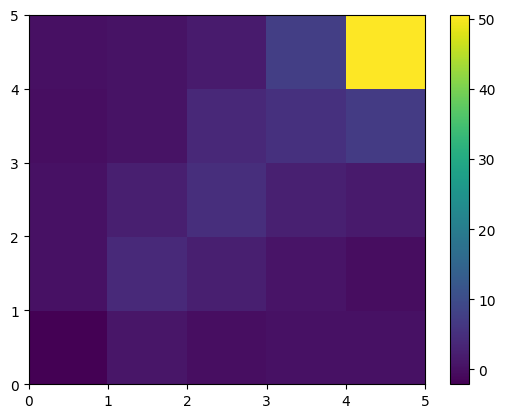

 80%|████████  | 400/500 [01:06<00:08, 11.78it/s]

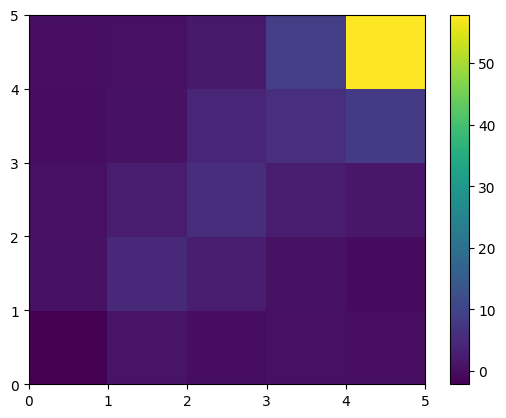

 90%|█████████ | 450/500 [01:11<00:04, 10.22it/s]

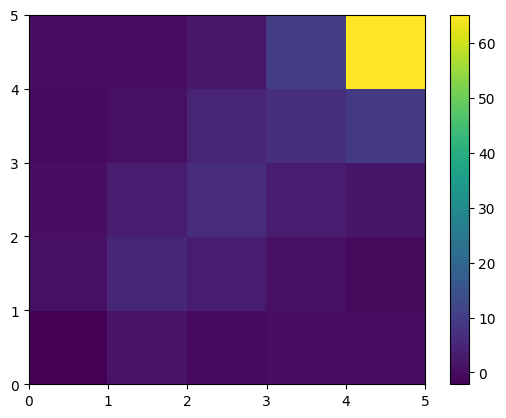

100%|██████████| 500/500 [01:16<00:00,  6.54it/s]


In [7]:
me = MaximumEntropy(gw, trajectories, features, lr, discount)
rewards = me.train(n_epochs, plot=True)

In [8]:
true_rewards = np.array([gw.reward(s) for s in range(grid_size*grid_size)]).reshape(grid_size, grid_size)

In [9]:
rewards = rewards.reshape(grid_size, grid_size)

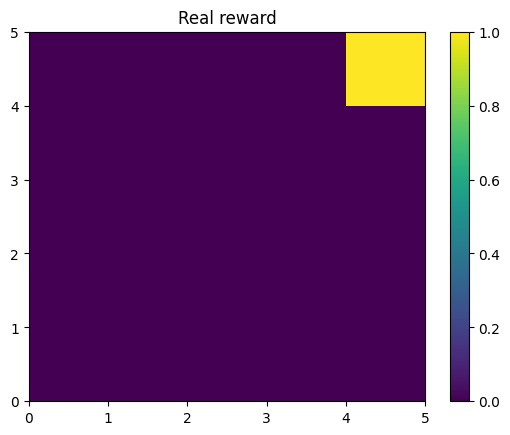

In [10]:
plt.pcolor(true_rewards)
plt.colorbar()
plt.title("Real reward")
plt.show()

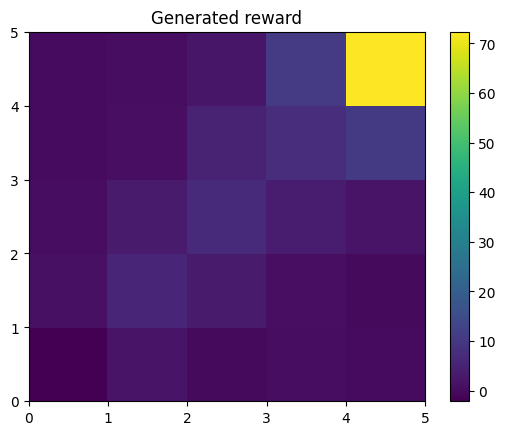

In [11]:
plt.pcolor(rewards)
plt.colorbar()
plt.title("Generated reward")
plt.show()

## ObjectWorld

The objectworld is an N×N grid of states with five actions per state, corresponding to steps in each direction and staying in place. Each action has a 30% chance of moving in a different random direction. Randomly placed objects populate the objectworld, and each is assigned one of C inner and outer colors. Object placement is randomized in the transfer environments, while N and C remain the same. There are 2C continuous features, each giving the Euclidean distance to the nearest object with a specific inner or outer color. In the discrete feature case, there are 2CN binary features, each one an indicator for a corresponding continuous feature being less than d ∈ {1, ...,N}. The true reward is positive in states that are both within 3 cells of outer color 1 and 2 cells of outer color 2, negative within 3 cells of outer color 1, and zero otherwise. Inner colors and all other outer colors are distractors.

In [12]:
class WorldObject(object):
    def __init__(self, inner_color, outer_color):
        self.inner_color = inner_color
        self.outer_color = outer_color

class Objectworld:
    def __init__(self, grid_size, n_objects, n_colors, wind, discount):
        self.wind = float(wind)
        self.grid_size = grid_size
        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1), (0, 0))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.n_objects = n_objects
        self.n_colors = n_colors
        self.discount = discount

        self.objects = {}
        for _ in range(self.n_objects):
            obj = WorldObject(np.random.randint(self.n_colors),
                              np.random.randint(self.n_colors))
            while True:
                x = np.random.randint(self.grid_size)
                y = np.random.randint(self.grid_size)

                if (x, y) not in self.objects:
                    break
            self.objects[x, y] = obj

        self.dynamics = self.transition_probabilities()
        self.real_rewards = np.array([self.reward(s) for s in range(self.n_states)])


    def feature_vector(self, state, discrete=True):
        x_s, y_s = state%self.grid_size, state//self.grid_size

        nearest_inner = {}
        nearest_outer = {}

        for y in range(self.grid_size):
            for x in range(self.grid_size):
                if (x, y) in self.objects:
                    dist = math.hypot((x - x_s), (y - y_s))
                    obj = self.objects[x, y]
                    if obj.inner_color in nearest_inner:
                        if dist < nearest_inner[obj.inner_color]:
                            nearest_inner[obj.inner_color] = dist
                    else:
                        nearest_inner[obj.inner_color] = dist
                    if obj.outer_color in nearest_outer:
                        if dist < nearest_outer[obj.outer_color]:
                            nearest_outer[obj.outer_color] = dist
                    else:
                        nearest_outer[obj.outer_color] = dist

        for c in range(self.n_colors):
            if c not in nearest_inner:
                nearest_inner[c] = 0
            if c not in nearest_outer:
                nearest_outer[c] = 0

        if discrete:
            state = np.zeros((2*self.n_colors*self.grid_size,))
            i = 0
            for c in range(self.n_colors):
                for d in range(1, self.grid_size+1):
                    if nearest_inner[c] < d:
                        state[i] = 1
                    i += 1
                    if nearest_outer[c] < d:
                        state[i] = 1
                    i += 1
        else:
            state = np.zeros((2*self.n_colors))
            i = 0
            for c in range(self.n_colors):
                state[i] = nearest_inner[c]
                i += 1
                state[i] = nearest_outer[c]
                i += 1

        return state


    def feature_matrix(self, discrete=True):
        return np.array([self.feature_vector(i, discrete)
                         for i in range(self.n_states)])


    def reward(self, state_p):
        x, y = state_p%self.grid_size, state_p//self.grid_size

        near_c0 = False
        near_c1 = False
        for (dx, dy) in product(range(-3, 4), range(-3, 4)):
            if 0 <= x + dx < self.grid_size and 0 <= y + dy < self.grid_size:
                if (abs(dx) + abs(dy) <= 3 and
                        (x+dx, y+dy) in self.objects and
                        self.objects[x+dx, y+dy].outer_color == 0):
                    near_c0 = True
                if (abs(dx) + abs(dy) <= 2 and
                        (x+dx, y+dy) in self.objects and
                        self.objects[x+dx, y+dy].outer_color == 1):
                    near_c1 = True
        if near_c0 and near_c1:
            return 1
        if near_c0:
            return -1
        return 0


    def reset(self, random=False):
        if random:
            self.state = np.random.randint(self.n_states)
        else:
            self.state = 0
        return self.state


    def step(self, a):
        probs = self.dynamics[:, a, self.state]
        self.state = np.random.choice(self.n_states, p=probs)
        return self.state


    def transition_probabilities(self):
        dynamics = np.zeros((self.n_states, self.n_actions, self.n_states))
        # S_t+1, A_t, S_t
        for s in range(self.n_states):
            x, y = s%self.grid_size, s//self.grid_size
            for a in range(self.n_actions):
                x_a, y_a = self.actions[a]
                for d in range(self.n_actions):
                    x_d, y_d = self.actions[d]
                    if 0 <= x+x_d < self.grid_size and 0 <= y+y_d < self.grid_size:
                        dynamics[(x+x_d) + (y+y_d)*self.grid_size, a, s] += self.wind/self.n_actions
                    else:
                        dynamics[s, a, s] += self.wind/self.n_actions
                if 0 <= x+x_a < self.grid_size and 0 <= y+y_a < self.grid_size:
                    dynamics[(x+x_a) + (y+y_a)*self.grid_size, a, s] += 1 - self.wind
                else:
                    dynamics[s, a, s] += 1 - self.wind

        return dynamics


    def optimal_policy(self):
        real_rewards = torch.tensor([self.reward(s) for s in range(self.n_states)], dtype=torch.float32)
        policy = value_iteration(0.0001, self, real_rewards, self.discount)
        return policy.argmax(1)


    def generate_trajectories(self, num, length, policy=None):
        if not policy:
            policy = self.optimal_policy()

        trajs = []
        for n in range(num):
            t = []
            state = self.reset(random=True)
            for i in range(length):
                action = policy[state]
                state_p = self.step(action)
                t.append([state, action, self.reward(state_p)])
                state = state_p
            trajs.append(t)
        return np.array(trajs)

In [55]:
grid_size = 5
n_objects = 4
n_colors = 2
wind = 0.3
discount = 0.9

num_trajectories, len_trajectory = 300, 30
n_epochs = 500
lr = 0.001

In [56]:
ow = Objectworld(grid_size, n_objects, n_colors, wind, discount)
trajectories = ow.generate_trajectories(num_trajectories, len_trajectory)
features = ow.feature_matrix(discrete=True)

In [60]:
true_rewards = np.array([ow.reward(s) for s in range(grid_size*grid_size)]).reshape(grid_size, grid_size)

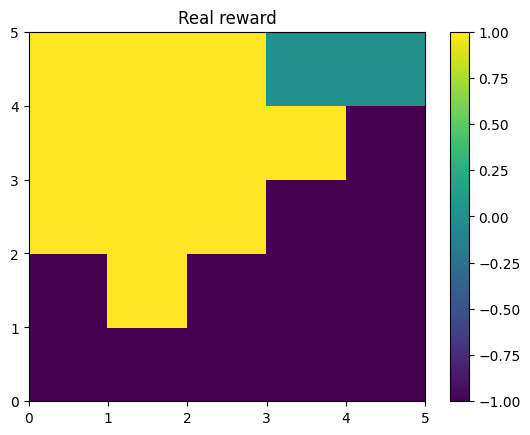

In [63]:
plt.pcolor(true_rewards)
plt.colorbar()
plt.title("Real reward")
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

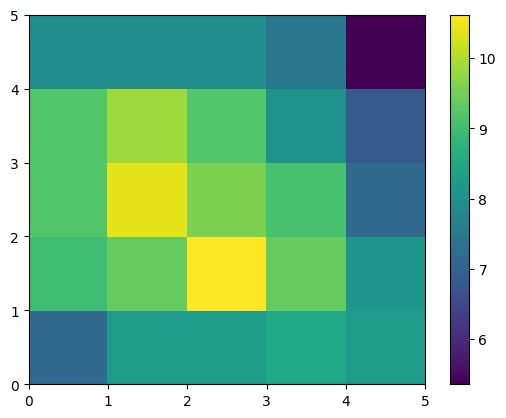

 10%|█         | 50/500 [00:05<00:48,  9.24it/s]

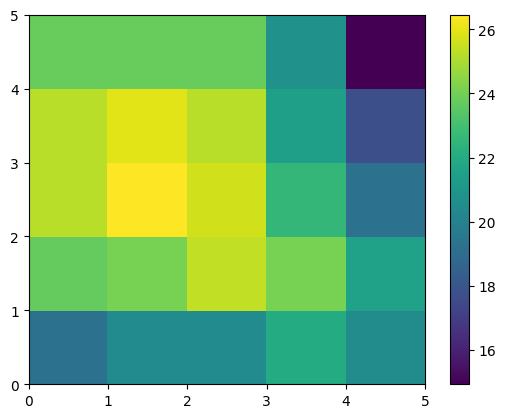

 20%|██        | 100/500 [00:12<01:15,  5.27it/s]

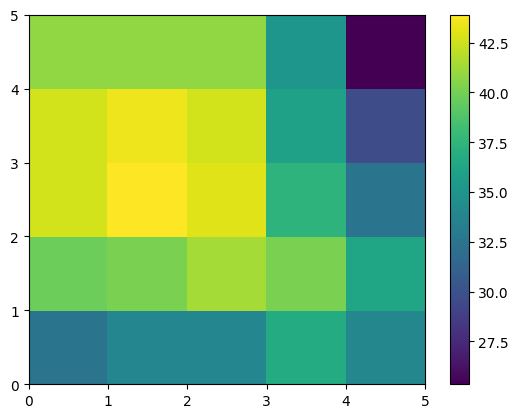

 30%|███       | 150/500 [00:18<00:38,  9.03it/s]

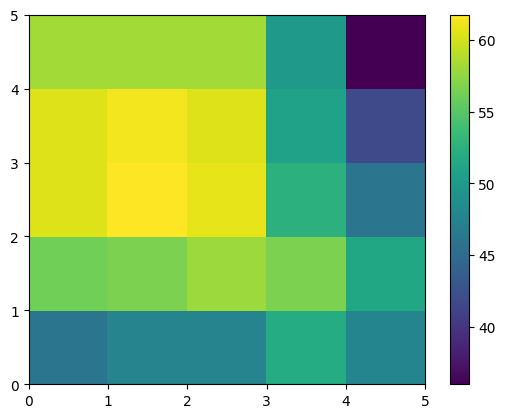

 40%|████      | 200/500 [00:25<00:56,  5.36it/s]

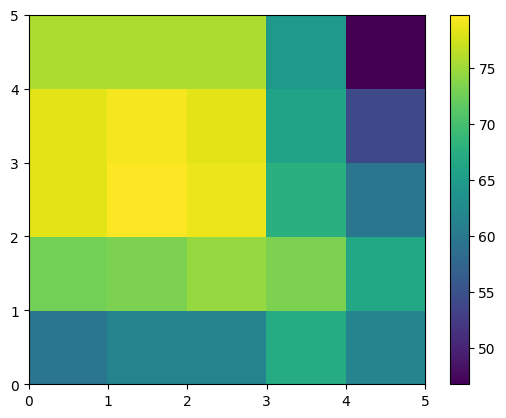

 50%|█████     | 250/500 [00:31<00:26,  9.27it/s]

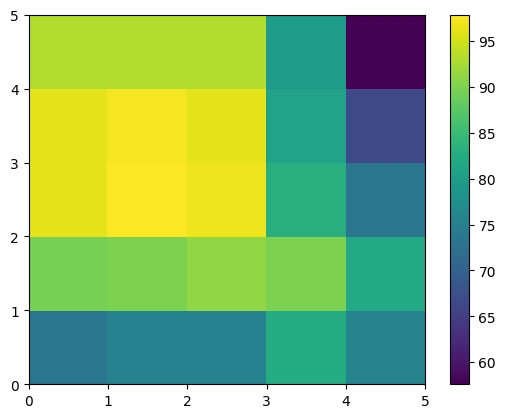

 60%|██████    | 300/500 [00:37<00:32,  6.13it/s]

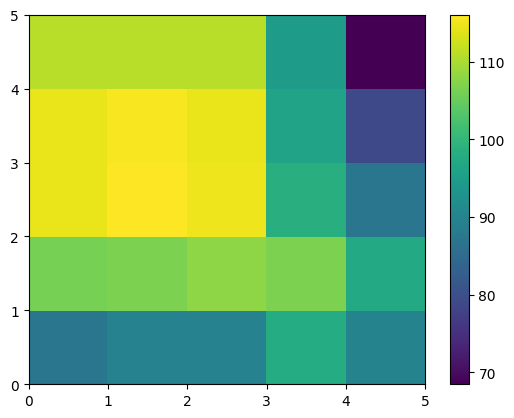

 70%|███████   | 350/500 [00:45<00:16,  9.36it/s]

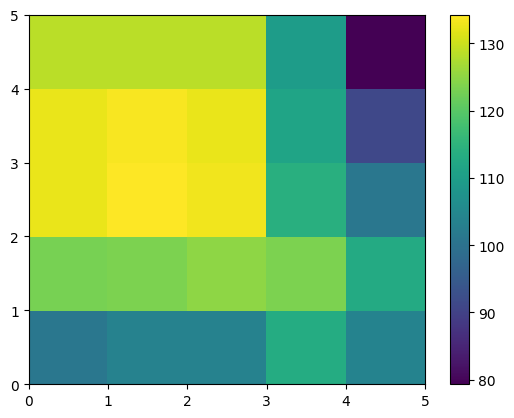

 80%|████████  | 400/500 [00:52<00:19,  5.19it/s]

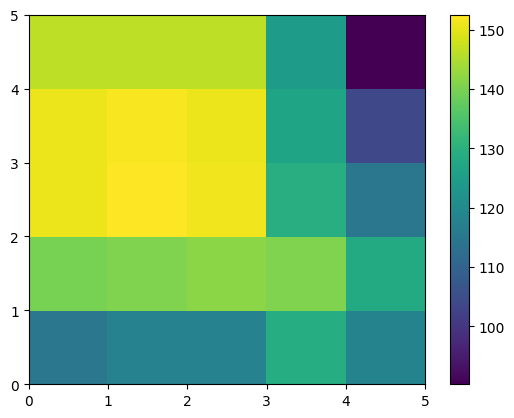

 90%|█████████ | 450/500 [00:58<00:05,  8.96it/s]

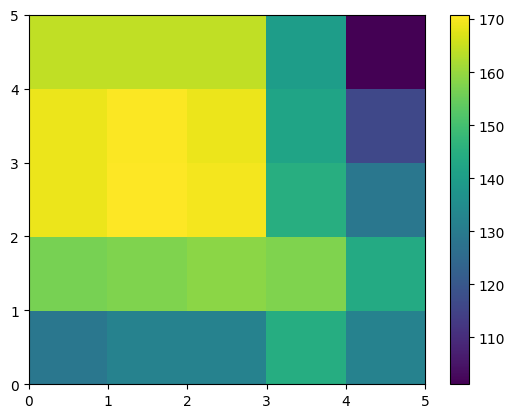

100%|██████████| 500/500 [01:05<00:00,  7.69it/s]


In [59]:
me = MaximumEntropy(ow, trajectories, features, lr, discount)
rewards = me.train(n_epochs, plot=True)

In [61]:
rewards = rewards.reshape(grid_size, grid_size)

In [62]:
true_rewards.shape

(5, 5)

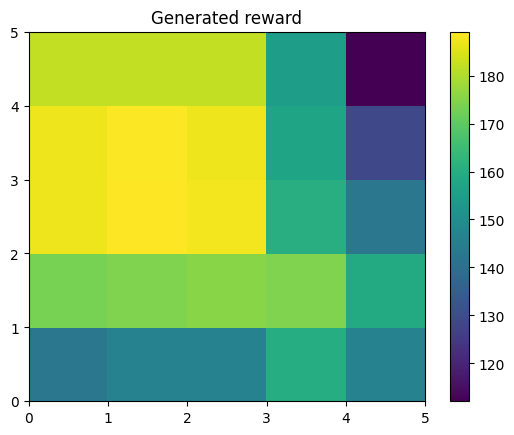

In [64]:
plt.pcolor(rewards)
plt.colorbar()
plt.title("Generated reward")
plt.show()